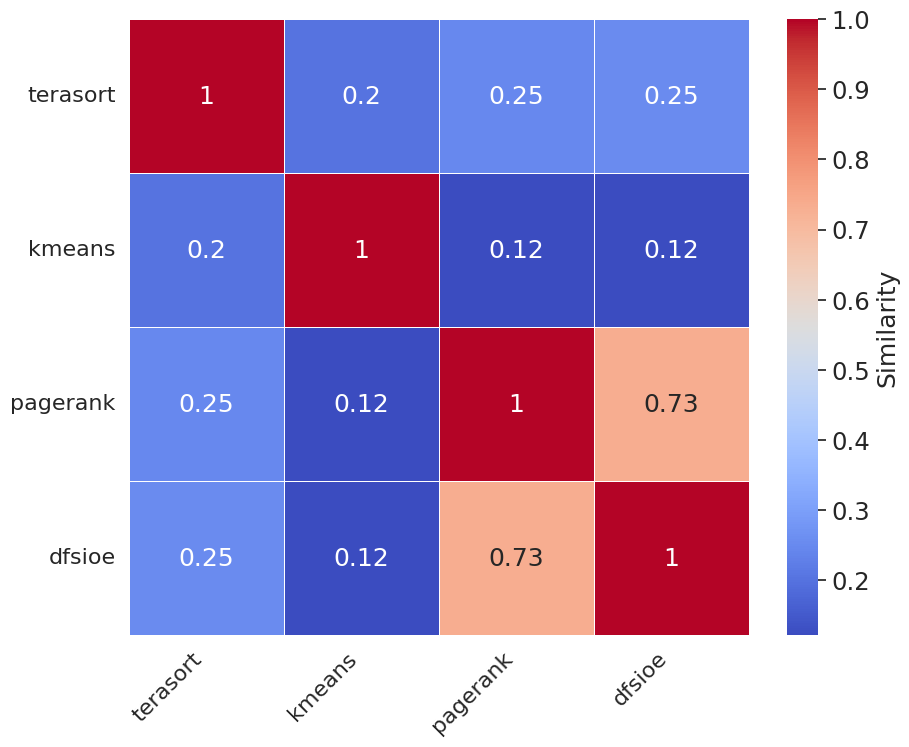

In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Define the cosine similarity function
def cosine_similarity(hist1, hist2):
    hist1 = np.array(hist1)
    hist2 = np.array(hist2)
    dot_product = np.dot(hist1, hist2)
    norm_hist1 = np.linalg.norm(hist1)
    norm_hist2 = np.linalg.norm(hist2)
    similarity = dot_product / (norm_hist1 * norm_hist2)
    return similarity

# Define the directory and metrics
folder = 'baseline'
output_base_dir = os.path.join(os.path.dirname(os.getcwd()), 'median')

metrics = {
    'cpu_usage_report_combined_median.csv': '%cpu_utilization',
    'memory_usage_report_combined_median.csv': '%memused',
}

# Function to create histogram from file for a specific application
def create_histogram(folder, application):
    hist = []
    for report, metric in metrics.items():
        file_path = os.path.join(output_base_dir, folder, report)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep=';')
            df_app = df[df['application'] == application]
            if not df_app.empty:
                hist.extend(df_app[metric].values)
            else:
                print(f"No data for application {application} in {file_path}.")
        else:
            print(f"File {file_path} does not exist.")
    return hist

# Define the applications of interest
applications_of_interest = ['terasort', 'kmeans', 'pagerank', 'dfsioe']

# Load the CSV files to get application list
cpu_usage_df = pd.read_csv(os.path.join(output_base_dir, folder, 'cpu_usage_report_combined_median.csv'), sep=';')

# Filter the applications
applications = [app for app in applications_of_interest if app in cpu_usage_df['application'].unique()]

# Dictionary to store histograms
histograms = {}

# Create histograms for each application
for app in applications:
    hist = create_histogram(folder, app)
    if hist:
        histograms[app] = hist

# Calculate pairwise similarities
similarity_matrix = pd.DataFrame(index=applications, columns=applications)

for app1 in applications:
    for app2 in applications:
        if app1 in histograms and app2 in histograms:
            hist1, hist2 = histograms[app1], histograms[app2]
            # Pad histograms to the same length
            max_len = max(len(hist1), len(hist2))
            if len(hist1) < max_len:
                hist1 = np.pad(hist1, (0, max_len - len(hist1)), 'constant')
            if len(hist2) < max_len:
                hist2 = np.pad(hist2, (0, max_len - len(hist2)), 'constant')
            similarity = cosine_similarity(hist1, hist2)
            similarity_matrix.loc[app1, app2] = similarity

# Convert similarity matrix to float
similarity_matrix = similarity_matrix.astype(float)

# Set font scale
sns.set(font_scale=1.6)

# Plot the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"size": 18}, cbar_kws={'label': 'Similarity'})
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Adjust colorbar label font size
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(18)

plt.show()
